In [2]:
# import public packages
import os
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle
import scipy
import mne
import sys

from mne.time_frequency import tfr_morlet
from mne.baseline import rescale
from scipy.signal import spectrogram, hann, butter, filtfilt, hilbert
from scipy import signal, interpolate, stats
from scipy.interpolate import make_interp_spline, BSpline
from io import open
from importlib import reload

# import own functions
from utils import find_folders
import dat_preproc
import fix_annot_onsets
import mat2fif
import baseline_correction
import normalization
import power_spectrum

### Add Directories/ Load Files

In [3]:
reload(find_folders)
onedrive = find_folders.get_onedrive_path()
project_path = find_folders.get_onedrive_path("entrainment")
print(project_path)

C:Users\mathiopv\OneDrive - Charité - Universitätsmedizin Berlin\ENTRAINMENT_PROJECT


In [ ]:
percept_ID = 'sub065'
fname = 'sub-20230307PStn_ses-2023061208395696_run-BrainSense20230612090400.mat'

raw = mne.io.read_raw_fieldtrip(
    os.path.join(
        project_path,
        'data',
        'raw_data',
        'with_med_FTG',
        fname
    ),
    info = None
)

subID = 'Sub065'

In [40]:
raw = mne.io.read_raw_fif(os.path.join(
    project_path,
        'data',
        'Fifs',
        'with_med_FTG',
        'Sub065_ARTREJECT_FIF.fif'
    )
)

subID = 'Sub065'

Opening raw data file C:Users\mathiopv\OneDrive - Charité - Universitätsmedizin Berlin\ENTRAINMENT_PROJECT\data\Fifs\with_med_FTG\Sub065_ARTREJECT_FIF.fif...
    Reading extended channel information
    Range : 0 ... 113699 =      0.000 ...   454.796 secs
Ready.


C:\Users\mathiopv\AppData\Local\Temp\ipykernel_8900\2772776688.py:1: RuntimeWarning: This filename (C:Users\mathiopv\OneDrive - Charité - Universitätsmedizin Berlin\ENTRAINMENT_PROJECT\data\Fifs\with_med_FTG\Sub065_ARTREJECT_FIF.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(os.path.join(


In [ ]:
%matplotlib qt
raw.plot(n_channels = 2)

In [ ]:
#First time making them
interactive_annot = raw.annotations
raw.annotations.save('Sub065_artefactsAnnotations1.csv', 
    overwrite = True)

In [ ]:
'''
my_annot = mne.Annotations(onset=new_onsets,  # in seconds
                           duration=interactive_annot.duration,  # in seconds, too
                           description=interactive_annot.description,
                           orig_time=raw.info['meas_date'])

reload(mat2fif)
%matplotlib qt
'''
new_raw = mat2fif.mat2fif(raw,interactive_annot)

In [ ]:
fif_name = os.path.join(project_path, 'data','Fifs','with_med_FTG','Sub065'+'_ARTREJECT_FIF.fif')
print(fif_name)

In [42]:
reload(dat_preproc)
%matplotlib qt
matplotlib.rc('font', size=10)
x = raw.get_data(reject_by_annotation = 'omit',picks=[0,1])
raw = raw
win_samp = 250
noverlap = 0.5
window = hann(win_samp, sym=False)
f, t, Sxx = dat_preproc.fft_rawviz(raw, x, win_samp, noverlap)


In [ ]:
new_raw.save(fif_name,overwrite=True)

In [43]:
fft_name = str(subID)+'_FFT'
print(fft_name)
fft_fig = os.path.join(project_path, 'figures','FFTs','with_med_FTG/')
plt.savefig(str(fft_fig)+str(fft_name)+'_EXEMPLARY.pdf')
plt.savefig(str(fft_fig)+str(fft_name)+'_EXEMPLARY', dpi = 400)


Sub065_FFT


In [ ]:
#Saving the figures & files
fft_fig = os.path.join(project_path, 'figures','FFTs','with_med_FTG/')
fft_file = os.path.join(project_path, 'data','FFTs','with_med_FTG/')

plt.savefig(str(fft_fig)+str(fft_name)+'_ARTREJECTED',dpi = 300)

np.save(str(fft_file)+str(fft_name)+'_ARTREJECTED.npy',Sxx)

In [ ]:
#Saving the raw data as a fif file
raw2 = raw.copy()
Draw = raw2.get_data()
info = raw.info
new_raw = mne.io.RawArray(Draw, info)

fif_name = os.path.join(project_path, 'data','switching_freqs','Sub050/',str(subID)+'_FIF_125.fif')
new_raw.save(fif_name, overwrite = True)


In [ ]:
#Zscore Normalization of raw data & plot of new figure
reload(baseline_correction)
data = Sxx
t = t
baseline = (None, None)
raw = raw
stim_ch = 1
bs_data = baseline_correction.baseline_corr(data, t, baseline, raw = raw, stim_ch = 4)

In [ ]:
fft_fig = os.path.join(project_path, 'figures','FFts','test/')
fft_file = os.path.join(project_path, 'data','FFTs','test/')

plt.savefig(str(fft_fig)+str(fft_name)+'_zscored',dpi = 300)
np.save(str(fft_file)+str(fft_name)+'_zscored'+'.npy',bs_data)

In [ ]:
d = {'onset': [65, 385, 443],
    'duration': [30, 30, 10],
    'description': ['StimOff','StimOn','Rebound']
}

epoch_df = pd.DataFrame(data = d)
print(epoch_df)

In [ ]:
## Print Power Spectra with Raw Data
reload(dat_preproc)
filt_dat = new_raw.get_data()
time_onsets = epoch_df
window = 250
noverlap = 0.5
ylim2 = 0.4

fig = plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
title1 = str(subID)+ '_LSTN'
ps1 = dat_preproc.epoch_ps(filt_dat, time_onsets, window, noverlap, 0, 0.3, title1)

plt.subplot(1,2,2)
title2 = str(subID)+ '_RSTN'
ps2 = dat_preproc.epoch_ps(filt_dat, time_onsets, window, noverlap, 1, 0.2, title2)

plt.show()

In [ ]:
## Printing the Power Spectra (RAW)
ps_all = np.concatenate((ps1,ps2), axis = 0)
ps_df = pd.DataFrame(np.transpose(ps_all),
    columns = ['StimOff_LSTN','StimOn_LSTN','Rebound_LSTN',
    'StimOff_RSTN','StimOn_RSTN','Rebound_RSTN'],
    )
print(ps_df)

In [ ]:
#Saving the figures & files
fft_fig = os.path.join(project_path, 'figures','Power_Spectra','without_med_FTG/')
fft_file = os.path.join(project_path, 'data','power_spectra','without_med_FTG/')

plt.savefig(str(fft_fig)+str(fft_name)+'_PS',dpi = 150)
ps_df.to_csv(str(fft_file)+str(fft_name)+'_PS.csv')

In [ ]:
## Print Power Spectra with Zscored Data
fig, axes = plt.subplots(1,1, figsize = (8,6))

side = 0

ps_m1s0 = np.mean(bs_data[side,:,epoch_df.onset[0]:epoch_df.onset[0]+ epoch_df.duration[0]],1)
ps_m1s1 = np.mean(bs_data[side,:,epoch_df.onset[1]:epoch_df.onset[1]+ epoch_df.duration[1]],1)
ps_reb = np.mean(bs_data[side,:,epoch_df.onset[2]:epoch_df.onset[2]+ epoch_df.duration[2]],1)

plt.plot(np.arange(1,127),ps_m1s0,label = epoch_df.description[0])
plt.plot(np.arange(1,127),ps_m1s1,label = epoch_df.description[1])
plt.plot(np.arange(1,127),ps_reb,label = epoch_df.description[2])
    
plt.xlim(60,90)
plt.xlabel('Frequency [Hz]')
plt.ylabel('LFP Power (z-scored)')
    
plt.legend()
plt.show()


In [ ]:
ps_allzscored_df = pd.DataFrame(
    {
        'Spontan': ps_m1s0,
        'StimOn': ps_m1s1,
        'Rebound': ps_reb
    }
)
print(ps_allzscored_df)

In [ ]:
plt.savefig(str(fft_fig)+str(fft_name)+'_Contra_zscoredPS',dpi = 150)
ps_allzscored_df.to_csv(str(fft_file)+str(fft_name)+'_Contra_zscoredPS.csv')

### Checking Spectral Width

In [ ]:
#Import the power spectrum csv
ps_tbl = pd.read_csv(os.path.join(
    project_path,
        'data',
        'power_spectra',
        'with_med_FTG',
        'Sub065_FFT_PS.csv'
))

subID = 'Sub065'

x1 = ps_tbl.StimOff_LSTN[50:101]
x2 = ps_tbl.StimOn_LSTN[50:101]
plt.plot(np.arange(0,51),x1)
plt.plot(np.arange(0,51),x2)
plt.xticks(np.arange(0,51,10), labels = np.arange(50,101,10))

plt.ylim(0,0.4)

In [ ]:
reload(power_spectrum)
%matplotlib qt

height = 0.04

peaks1, results_half1, peaks2, results_half2 = power_spectrum.powerSpectrum_width(x1, x2, height, subID)
print(results_half1)
print(results_half2)

In [ ]:
plt.savefig(os.path.join(
    project_path,
    'figures',
    'Power_Spectra',
    'with_med_FTG',
    str(subID)+'_PSWidth'
),
dpi = 150)

### Average all Power Spectra and Plot them

In [ ]:
## Interpolate and plot power spectrum
trial_ps = pd.read_csv(os.path.join(
    project_path,
        'data',
        'power_spectra',
        'test',
        'Sub005_FFT_PS.csv'
)
)

print(trial_ps)

In [ ]:
reload(dat_preproc)
dat_preproc.mypower(trial_ps['StimOff_RSTN'])
dat_preproc.mypower(trial_ps['StimOn_RSTN'])
plt.xlim(50,100)

In [ ]:
os.path.join(
   project_path,
   'data', 'power_spectra', 'test'
)

In [ ]:
print(ps_path)

In [ ]:
#loop through all csv files in ZSCORED
from scipy import stats
import glob

all_spontan = []
all_subh = []
col_names = []

ps_path = os.path.join(
   project_path,
   'data', 'power_spectra', 'with_med_FTG'
)

'''
for filename in os.listdir(ps_path):
   if filename.endswith('FFT_Ipsi_zscoredPS.csv'):
   #with open(os.path.join(ps_path, filename), 'r') as f: # open in readonly mode
      this_df = pd.read_csv(os.path.join(ps_path,filename))
      this_spontan = this_df['Spontan']
      this_subh = this_df['StimOn']


      all_spontan.append(this_spontan)
      all_subh.append(this_subh)

'''
pattern = os.path.join(ps_path, '*FFT_PS.csv')
file_list = glob.glob(pattern)



for file_path in file_list:
   filename = os.path.basename(file_path)
   if filename.startswith('Sub006') or filename.startswith('Sub045') or filename.startswith('Sub065'):
   #with open(os.path.join(ps_path, filename), 'r') as f: # open in readonly mode
         this_df = pd.read_csv(os.path.join(ps_path,filename))
         this_spontan = this_df['StimOff_LSTN']
         this_subh = this_df['StimOn_LSTN']
   else: 
         this_df = pd.read_csv(os.path.join(ps_path,filename))
         this_spontan = this_df['StimOff_RSTN']
         this_subh = this_df['StimOn_RSTN']
   sub_id = filename.split('_')[0]
   
   all_spontan.append(this_spontan)
   all_subh.append(this_subh)
   col_names.append(sub_id)


In [ ]:
all_spontan_df = pd.DataFrame(np.transpose(all_spontan))
all_subh_df = pd.DataFrame(np.transpose(all_subh))
all_spontan_df.columns = col_names
print(all_spontan_df)

In [ ]:
all_spontan_df.to_excel(os.path.join(
    project_path,
   'data', 'power_spectra',
   'SpontanPS_with.xlsx'
))

Plot only the subharmonics and color code the Power Spectra

In [ ]:
#### IMPORT THEM ####
ps_path = 'data//power_spectra//'

df_without = pd.read_excel(os.path.join(
    project_path,
    ps_path,
    'SubharmPS_without.xlsx'
))

df_with = pd.read_excel(os.path.join(
    project_path,
    ps_path,
    'SubharmPS_with.xlsx'
))

all_subharms = [df_without, df_with]
all_subharms = pd.concat(all_subharms, axis = 1)

'''
#### SAVE IT ###
all_subharms.to_excel(os.path.join(
    project_path,
   'data', 'power_spectra',
   'All_Subharmonics62_PS.xlsx'
))
'''

In [ ]:
all_subharms = pd.read_excel(os.path.join(
    project_path,
    'data',
    'power_spectra',
    'All_Subharmonics62_PS.xlsx'
))

In [ ]:
#### PLOT THE PS TOGETHER AND COLOR CODE THE DIFFERENT STIM FREQS ####
%matplotlib qt
colDict = {}
legend_dict = {}
for key in ['Sub007', 'Sub005', 'Sub006','Sub009','Sub014']:
    colDict[key] = 130
for key in ['Sub021', 'Sub025','Sub028','Sub033','Sub043','Sub050','Sub017','Sub045','Sub065']:
    colDict[key] = 125

handles = []
labels = []

for col in all_subharms.columns:
    if col in colDict and colDict[col] == 130:
        line, = plt.plot(all_subharms[col], color='midnightblue')
        if 'Stim 130Hz' not in labels:
            handles.append(line)
            labels.append('Stim 130Hz')
    elif col in colDict and colDict[col] == 125:
        line, = plt.plot(all_subharms[col], color='crimson')
        if 'Stim 125Hz' not in labels:
            handles.append(line)
            labels.append('Stim 125Hz')
    else:
        plt.plot(all_subharms[col])

# Add labels and legend
plt.ylabel('LFP Power')
plt.xlabel('Frequency [Hz]')

plt.legend(handles, labels)

plt.xlim(50,90)
plt.ylim(0,0.5)

In [ ]:
plt.savefig(os.path.join(
    project_path,
    'figures',
    'Power_Spectra',
    'All_Subharmonics_PS'
),
dpi = 200)

plt.savefig(os.path.join(
    project_path,
    'figures',
    'Power_Spectra',
    'All_Subharmonics_PS.svg'
))

In [ ]:
%matplotlib qt
plt.plot(all_spontan_df,color = '#1f77b4',lw = 1, alpha = 1, label = 'Med On-Stim Off')
plt.plot(all_subh_df,color = 'red',lw = 1, alpha = 1, label = 'Med On-Stim On')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlim(50,90)
plt.ylim(0,0.5)
plt.xlabel('Frequency [Hz]')
plt.ylabel('LFP Power')

In [ ]:
plt.savefig(os.path.join(
    project_path,
    'figures',
    'Power_Spectra',
    'with_med_FTG',
    'AllSub_Ipsi_PowerSpectra'
),
dpi = 200)

In [ ]:
all_psSpontan = pd.read_csv(os.path.join(
    project_path,
        'results',
        'AllSpontan_PsZscored.csv'
))


all_psSubharm = pd.read_csv(os.path.join(
    project_path,
        'results',
        'AllSubharm_PsZscored.csv'
))

In [ ]:
all_psSpontan = all_psSpontan.drop('Sub029', axis=1)

In [ ]:
all_ps_mean1 = np.mean(all_psSpontan,1)
all_ps_sem1 = stats.sem(all_psSpontan,1)

all_ps_mean2 = np.mean(all_psSubharm,1)
all_ps_sem2 = stats.sem(all_psSubharm,1)

In [ ]:
plt.plot(np.arange(1,127), all_ps_mean1, label = 'Spontaneous FTG')
plt.fill_between(np.arange(1,127), all_ps_mean1-all_ps_sem1, all_ps_mean1+all_ps_sem1, alpha = 0.2)

plt.plot(np.arange(1,127), all_ps_mean2, label = 'DBS-Induced FTG')
plt.fill_between(np.arange(1,127), all_ps_mean2-all_ps_sem2, all_ps_mean2+all_ps_sem2, alpha = 0.2)

plt.xlim(50, 100)
plt.ylim(-0.4, 2)
plt.legend()

plt.xlabel('Frequency [Hz]')
plt.ylabel('LFP Power [z-scored]')
plt.title('Averaged Power Spectra [N = 6]')

In [ ]:
plt.savefig(os.path.join(
    project_path,
    'results',
    'Avg_PS'
),
dpi = 200)

In [ ]:
###Compare Power Spectra Widths

widths_tbl = pd.read_csv(os.path.join(
    project_path,
    'results',
    'PS_Widths.csv'
))
print(widths_tbl)

In [45]:
import mlxtend
import seaborn as sns

In [ ]:
widths_all = np.concatenate((widths_tbl['WidthMed'],widths_tbl['WidthSubh']), axis = 0)
val_all = np.concatenate((np.repeat(0,8), np.repeat(1,8)), axis = 0)
widths_dict = {
    'widths': widths_all,
    'conds': val_all,
    'paired':[1,2,3,4,5,6,7,8,1,2,3,4,5,6,7,8]
}

df1=pd.DataFrame.from_dict(widths_dict)
print(df1)

In [ ]:
%matplotlib qt
ax = sns.boxplot(x='conds',y='widths',data=df1, boxprops=dict(alpha=.8), width = 0.3)
sns.stripplot(data=df1, x='conds',y='widths', jitter = 0, size = 10, edgecolor = 'black')
sns.lineplot(
    data=df1, x='conds',y='widths', units = 'paired',
    color=".7", estimator=None, 
    linestyle=':'
)
ax.set_xticklabels({'M1S0','M1S1'})
ax.set_xlabel('')
ax.set_ylabel('Widths [Freq Bins]')
plt.text(0.9,2.4,'p = .008')
plt.rcParams.update({'font.size': 15})

In [ ]:
p_value = mlxtend.permutation_test(
    widths_tbl['WidthMed'], widths_tbl['WidthSubh'], paired=True, method="approximate", seed=0, num_rounds=100000
)

print(p_value)

In [ ]:
np.round(p_value,decimals = 3)

In [ ]:
plt.savefig(os.path.join(
    project_path,
    'results',
    'PS_Widths'
),
dpi = 200)

In [ ]:
cdrs_df = pd.read_excel(os.path.join(
    project_path,
    'results',
    'Trial_CDRSAll.xlsx'
))
print(cdrs_df)

In [ ]:
score1 = cdrs_df.loc[(cdrs_df['Laterality'] == 'Total') & (cdrs_df['Cond'] == 1),"cdrs_score"]
score2 = cdrs_df.loc[(cdrs_df['Laterality'] == 'Total') & (cdrs_df['Cond'] == 3),"cdrs_score"]

p_value = mlxtend.permutation_test(
    np.array(score1), np.array(score2), paired=True, method="approximate", seed=0, num_rounds=100000
)

print(p_value)

In [ ]:
%matplotlib qt
sns.set_theme(style="ticks", palette="pastel")
ax = sns.boxplot(x='Cond',y='cdrs_score',hue = 'Laterality', palette = ['m','g'], data=cdrs_df, width = 0.7)
sns.stripplot(data=cdrs_df, x='Cond',y='cdrs_score',hue = 'Laterality', jitter = False, size = 10, dodge = True, palette = ['#7E1E9C','#054907'])
sns.lineplot(
    data=cdrs_df, x=cdrs_df['Cond']-1, y='cdrs_score', units= 'SubCode', hue = 'Laterality',
    color=".3",
    palette=['m','g'],
    linestyle=':', estimator = None
)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])
ax.set_ylim(-2,15)

ax.set_xlabel('')
ax.set_xticklabels(['M1S0','M1S1-PreSub','M1S1-Sub'])
ax.set_ylabel('CDRS Score')


In [ ]:
plt.savefig(os.path.join(
    project_path,
    'results',
    'CDRS_boxplot'
),
dpi = 200)

### Mean Bands 5Hz around the peak of the subharmonic

In [4]:
all_subh = pd.read_excel(os.path.join(
    project_path,
    'data',
    'power_spectra',
    'SubhPeaks_MeanBand.xlsx'
))

all_cond3 = pd.read_json(os.path.join(
    project_path,
    'results',
    'accelerometer',
    'inspections',
    'all_features_cond3.json'
))

all_spontan = pd.read_excel(os.path.join(
    project_path,
    'data', 'power_spectra',
    'SpontanPeaks_MeanBand.xlsx'
))
all_spontan


,Sub005,Sub006,Sub009,Sub014,Sub017,Sub029,Sub045,Sub065
0,0.042831,0.012105,0.014606,0.022366,0.018474,0.017919,0.037037,0.016144
1,0.115707,0.011407,0.015429,0.021659,0.016570,0.031946,0.042427,0.013062
2,0.295881,0.017273,0.036341,0.019275,0.044022,0.054410,0.026253,0.028121
3,0.338690,0.034147,0.053947,0.083503,0.118573,0.055170,0.015957,0.056637
4,0.221988,0.039265,0.032187,0.088392,0.095900,0.024520,0.012666,0.049561


In [5]:
mean_actSB = np.mean(all_subh, axis = 0)
mean_actSB_df = pd.DataFrame([mean_actSB.index,mean_actSB]).T
mean_actSB_df.columns = ['Percept_ID', 'Avg_Subh']

mean_actSP = np.mean(all_spontan, axis = 0)
mean_actSP_df = pd.DataFrame([mean_actSP.index,mean_actSP]).T
mean_actSP_df.columns = ['Percept_ID', 'Avg_Spontan']


mean_actSP_df

,Percept_ID,Avg_Spontan
0,Sub005,0.203019
1,Sub006,0.022839
2,Sub009,0.030502
3,Sub014,0.047039
4,Sub017,0.058708
5,Sub029,0.036793
6,Sub045,0.026868
7,Sub065,0.032705


In [6]:
merged_sbh_df = pd.merge(all_cond3, mean_actSB_df, on='Percept_ID', how = 'inner')
merged_sbh_df

,Percept_ID,coefVar_intraTapInt,coefVar_raise_velocity,freq,slope_impactRMS,coefVar_impactRMS,coefVar_tap_entropy,trace_entropy,jerkiness_trace,coefVar_tapRMS,mean_impactRMS,trace_RMSn,mean_raise_velocity,mean_tapRMS,slope_tap_entropy,slope_intraTapInt,Avg_Subh
0,Sub005,0.058943,0.105582,2.688172,-0.000864,0.075817,0.012444,7.601956,237.408036,0.062280,0.576218,0.020890,6.802151,0.555080,0.002596,0.001196,0.155675
1,Sub006,0.150645,0.354242,3.489608,0.000350,0.085819,0.054357,7.588290,282.696037,0.098576,0.541981,0.040802,9.983635,0.568474,0.003393,0.000903,0.032567
2,Sub021,0.164370,0.520930,2.253687,-0.022457,0.127210,0.082256,7.453163,200.209720,0.142968,1.960287,0.144954,60.926551,1.987160,0.016032,0.002819,0.092187
3,Sub025,0.069560,0.488108,2.731065,0.003384,0.101735,0.031355,7.359954,191.011205,0.106068,1.655626,0.138629,38.401303,1.686783,0.005843,0.000850,0.034591
4,Sub028,0.122569,0.661580,3.031010,-0.017043,0.110339,0.095061,7.339878,281.673601,0.153499,1.487271,0.115355,22.246943,1.737768,0.027768,0.002110,0.027836
5,Sub033,0.519226,0.728543,1.277947,-0.023526,0.245819,0.091836,7.463133,199.154336,0.177547,1.738515,0.081124,22.008322,1.475374,0.047046,0.050404,0.033088
6,Sub050,0.175332,0.474781,2.939944,-0.005118,0.064540,0.084726,7.627664,224.034492,0.080437,2.665992,0.194560,39.474030,2.706198,0.026051,0.004721,0.0369
7,Sub065,0.065869,0.299151,3.395586,0.008064,0.090305,0.055371,7.330680,302.843803,0.116955,1.765661,0.161229,33.086288,2.208969,0.005040,0.001081,0.134691


In [ ]:
merged_spontan_sbh_df = pd.merge(mean_actSB_df, mean_actSP_df, on='Percept_ID', how = 'inner')
merged_spontan_sbh_df

In [ ]:
from scipy.stats import shapiro, normaltest, kstest
_, kstest_p_value = kstest(y, 'norm')
kstest_p_value

0.530922861565801


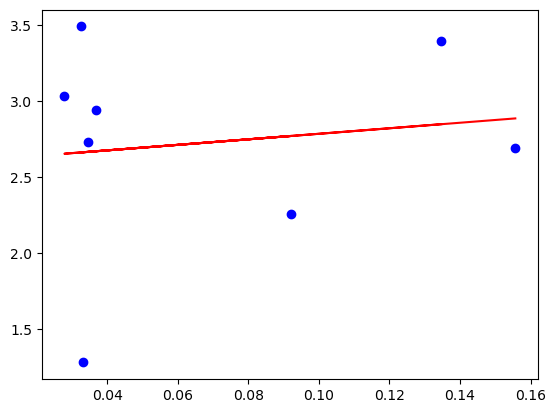

In [16]:
from scipy.stats import spearmanr, pearsonr

x = merged_sbh_df['Avg_Subh'].astype(np.float64)
y =  merged_sbh_df['freq'].astype(np.float64)


slope, intercept = np.polyfit(x, y, 1)
line = slope * x + intercept 
plt.scatter(x, y, color='blue', label='Data')
plt.plot(x, line, color='red', label='Least Squares Line')

rho, p_value = spearmanr(x, y)
print(p_value)

### Stim Parameters

In [ ]:
stim_pars = pd.read_excel(os.path.join(
    project_path,
    'results',
    'Amplitude_Dependent\\',
    'Stim_pars.xlsx'
))
print(stim_pars)

In [64]:
coh1 = stim_pars.loc[stim_pars['Cohort'] == 1, 'StartAmp']
coh2 = stim_pars.loc[stim_pars['Cohort'] == 2, 'StartAmp']

In [69]:
np.round(np.std(coh2), decimals = 2)

0.63

In [58]:
%matplotlib qt
ax = sns.boxplot(x='Cohort',y='EndAmp',data=stim_pars, boxprops=dict(alpha=.8), width = 0.3)
sns.stripplot(data=stim_pars, x='Cohort',y='EndAmp', jitter = 0, size = 10, edgecolor = 'black')

ax.set_xticklabels({'No peak M1S0','With peak M1S0'})
ax.set_xlabel('')
ax.set_ylabel('Stimulation Amplitude')
plt.rcParams.update({'font.size': 15})

In [72]:
p_value = mlxtend.permutation_test(
    coh1, coh2, paired=False, method="approximate", seed=0, num_rounds=100000
)

print(np.round(p_value, decimals = 3))

0.139


In [5]:
%matplotlib qt

fig, ax = plt.subplots(figsize = (8,8))

for i, row in stim_pars.iterrows():
    if row['Cohort'] == 1:
        ax.plot([row['StartAmp'], row['EndAmp']], [row['Index_AA']-1, row['Index_AA']-1], color='blue')
        ax.plot(row['StartAmp'], row['Index_AA']-1, '|', color='blue', mew = 2)
        ax.plot(row['EndAmp'], row['Index_AA']-1, '|', color='blue', mew = 2)
    else:
        ax.plot([row['StartAmp'], row['EndAmp']], [row['Index_AA']-1, row['Index_AA']-1], color='orange')
        ax.plot(row['StartAmp'], row['Index_AA']-1, '|', color='orange', mew = 2)
        ax.plot(row['EndAmp'], row['Index_AA']-1, '|', color='orange', mew = 2)

ax.plot(stim_pars['ClinicalAmp'], stim_pars['Index_AA']-1, '*', color='green', label='Clinical Amplitude', markersize = 8)
ax.plot(stim_pars['HighestAmp'], stim_pars['Index_AA']-1, '|', color='magenta', label='Highest Amplitude', markersize = 10)

ax.set_xlim(0,4)
ax.set_yticks(np.arange(0,15))
yticklabels = ['#{}'.format(i) for i in np.arange(1,16)]

ax.set_yticklabels(yticklabels)
ax.legend(loc = 'lower left')
ax.set_xlabel('Stimulation Amplitude [mA]')
ax.set_ylabel('STN')

Text(0, 0.5, 'STN')

In [6]:
plt.savefig(os.path.join(
    project_path,
    'results',
    'Amplitude_Dependent',
    'Stim_PARS'
),
dpi = 200)

plt.savefig(os.path.join(
    project_path,
    'results',
    'Amplitude_Dependent',
    'Stim_PARS.svg'
))

### Plot PS overlapping on point 63-65

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Generate example vectors
vector1 = np.random.rand(125, 1)  # First vector of size 125x1
vector2 = np.random.rand(125, 1)  # Second vector of size 125x1

# Create x-axis values
x = np.arange(1, 126)

# Plotting
plt.plot(x, vector1, label="Vector 1")
plt.plot(x[2:], vector2[:-2], label="Vector 2")  # Shift Vector 2 by 2 points to align with Vector 1

# Labeling and legend
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()

# Display the plot
plt.show()




In [13]:
'''Frequency tracking algorithms are used to estimate and track the frequency of a signal over time. 
One commonly used algorithm for frequency tracking is the Phase-Locked Loop (PLL) algorithm. H
ere's an example of how you can implement a basic frequency tracking algorithm using a PLL in Python:'''

import numpy as np
import matplotlib.pyplot as plt

# Generate example signal
t = np.linspace(0, 1, num=1000)  # Time vector
f0 = 82  # Initial frequency
signal = np.sin(2 * np.pi * f0 * t)  # Signal with initial frequency

# Parameters for PLL
sampling_rate = 250  # Sampling rate of the signal
loop_filter_gain = 0.1  # Loop filter gain
phase_error_integration_gain = 0.01  # Gain for integrating phase error
vco_gain = 1  # Voltage-controlled oscillator gain

# Variables for frequency tracking
phase = 0  # Initial phase
frequency_estimate = f0  # Initial frequency estimate

# Variables for plotting
frequency_estimates = []  # Store frequency estimates over time

# Frequency tracking loop
for i in range(len(signal)):
    # Generate VCO output
    vco_output = np.sin(2 * np.pi * phase)

    # Update phase based on the VCO output and frequency estimate
    phase += 2 * np.pi * frequency_estimate / sampling_rate

    # Calculate phase error
    phase_error = np.angle(signal[i] * np.conj(vco_output))

    # Update frequency estimate using the phase error
    frequency_estimate += phase_error * phase_error_integration_gain

    # Store frequency estimate
    frequency_estimates.append(frequency_estimate)

# Plotting
plt.plot(t, signal, label="Original Signal")
plt.plot(t, frequency_estimates, label="Frequency Estimate")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


